## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, fixed

from dtaidistance import dtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 4)
pd.options.display.max_columns = 500

## Load

In [2]:
daily_train = pd.read_csv("../data/processed/daily-train-base.csv", parse_dates=["ds"])
daily_train

,id,ds,t,y,category
0,1,1994-03-01 12:00:00,1,1017.1,Macro
1,1,1994-03-02 12:00:00,2,1019.3,Macro
2,1,1994-03-03 12:00:00,3,1017.0,Macro
3,1,1994-03-04 12:00:00,4,1019.2,Macro
4,1,1994-03-05 12:00:00,5,1018.7,Macro
...,...,...,...,...,...
9964653,4227,2012-04-22 12:00:00,4436,15111.5,Other
9964654,4227,2012-04-23 12:00:00,4437,15154.0,Other
9964655,4227,2012-04-24 12:00:00,4438,15208.6,Other
9964656,4227,2012-04-25 12:00:00,4439,15108.0,Other


## Cluster

In [3]:
tss = [
    daily_train.loc[daily_train.id == k, ["ds", "y"]].set_index("ds").y 
    for k in range(1, 4227+1)
]

tss_array = [ts.to_numpy() for ts in tss]

tss_array_scaled = [StandardScaler().fit_transform(ts.reshape(-1, 1)).flatten() for ts in tss_array]

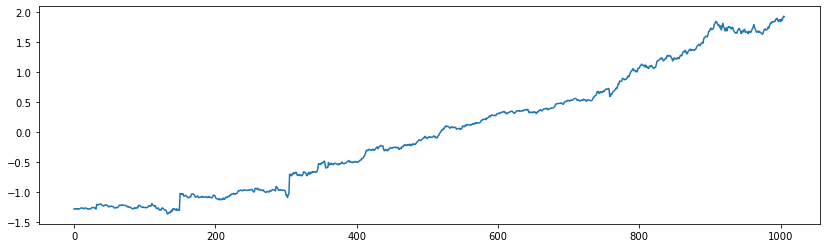

In [4]:
plt.plot(tss_array_scaled[0])

In [5]:
n_samples = len(tss_array_scaled)
np.random.shuffle(tss_array_scaled)
tss_array_sample = tss_array_scaled[:n_samples]

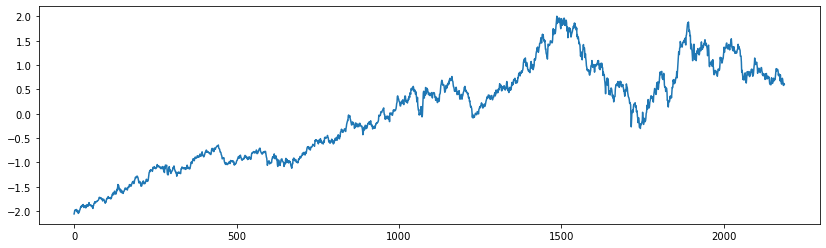

In [6]:
plt.plot(tss_array_sample[0])

In [ ]:
%timeit -r1
distances = dtw.distance_matrix_fast(tss_array_sample, compact=True, use_pruning=True)
distances = np.array(distances)

In [9]:
np.savetxt("../data/processed/daily_distances.csv", distances)

In [11]:
Z = linkage(distances, method="complete")

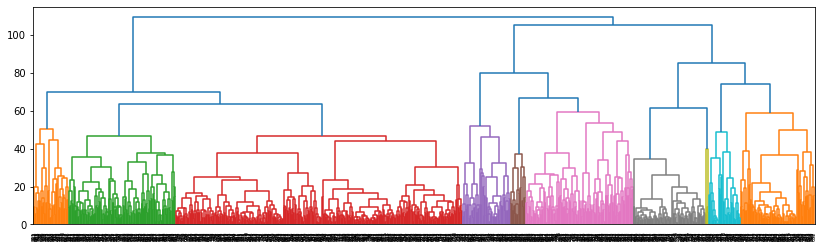

In [23]:
dn = dendrogram(Z, color_threshold=60)

In [24]:
# clusters = fcluster(Z, t=5, criterion="maxclust")
clusters = fcluster(Z, t=60, criterion="distance")
pd.Series(clusters).value_counts()

3     367
6     138
2     137
10     95
7      93
4      62
1      45
9      40
5      19
8       4
dtype: int64

In [26]:
label_ui = (1, clusters.max())
n_plots_ui = (2, 20, 2)
width_ui = (4, 20)
height_ui = (4, 20)

@interact(label=label_ui, n_plots=n_plots_ui, width=width_ui, height=height_ui)
def plot_cluster_sample(label=1, n_plots=10, width=14, height=6):
    idxs_cluster = tuple(np.where(clusters == label)[0])
    tss_cluster = [tss_array_sample[i] for i in idxs_cluster]
    np.random.shuffle(tss_cluster)
    tss_cluster = tss_cluster[:n_plots]

    n_cols = 2
    f, axs = plt.subplots(n_plots // n_cols, n_cols, figsize=(width, height))
    for ts, ax in zip(tss_cluster, np.ravel(axs)):
        ax.plot(ts)
    plt.tight_layout()

interactive(children=(IntSlider(value=1, description='label', max=10, min=1), IntSlider(value=10, description=…